In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline
import seaborn as sns
sns.set_context('talk')

from matplotlib.animation import FuncAnimation
import netCDF4 as nc

In [2]:
#SENSITIVITY ANALYSIS
#Assume independence between variables so that first order sensitivities are enough

#set variable means x_i
#run simulation to obtain quantity of interest Q
#get the mean Q_0
#give nominated variances to variables - 1%? as var_i, sigma_i = sqrt(var_i)
#run simulation (num of variables) times with perturbed variables by h = eps*x_i
#get first order sensitivity (Q(x_i)-Q_0)/h
#obtain vector of sensitivities dQ_dx
#Calculate covariance matrix (only diagonal terms here) Sigma
#Obtain variance in Q via var_Q = dQ_dx.T @ Sigma @ dQ_dx
#Obtain uncertainty estimate via sigma_Q = sqrt(var_Q)

In [3]:
#VARIABLES

#temp
#rad
#thick
#rr_coef
#dif_coef
#init_c
#max_c
#vol_per
#iapp

In [4]:
#Set mean of variables here
#as well as initial dataframe
#mu should be a 9x1 array
params = ['temp','rad','thick','rr_coef','dif_coef','init_c','max_c','vol_per','iapp']
mu = np.array([294.15, 5.22e-6, 75.6e-6, 3.42, 1.48e-15, 47023.326, 51765.0, 66.5, 48.685491723466406])
volts_df = pd.DataFrame(dict(parameter=params,mu=mu))

#Auxilliary 2D array of variable means, identical columns
Mu_s = np.tile(mu.reshape((9,1)),(1,1000))

#Set value of perturbation here
#h_i = eps*mu_i
#Set h as a matrix for element-wise division, identical columns with elements = h_i
eps = 1e-6
h_i = (eps*mu).reshape((9,1))
h = np.tile(h_i,(1, 1000))

#Obtain mean voltage curve V_0 here, each row identical
#9 rows representing variables
#1000 columns representing timesteps
V_0 = np.zeros((9,1000))
dat = nc.Dataset("./sens_analysis_data/SP_output_0.nc", "r", format="NETCDF4")
volt = dat['volt'][:][:,0]
volt_0 = np.array(volt)
V_0 = np.tile(volt, (9, 1))

In [5]:
#Obtain perturbed voltages here
#9 rows representing variables
#1000 columns representing timesteps
Vs = np.zeros((9,1000))

for i in range(1, 10, 1):
    dat = nc.Dataset(f"./sens_analysis_data/SP_output_{i}.nc", "r", format="NETCDF4")
    Vs[i-1, :] = np.array(dat['volt'][:][:,0])

In [6]:
#Compute dV/dx as a function of time
dV_dx = np.divide((Vs - V_0),h)

#Compute absolute scaled sensitivity using element-wise multiplication
V_first_sensitivities = np.abs(Mu_s*dV_dx)

#each column i of the matrix represents the sensitivities for each paramter at time t=i 

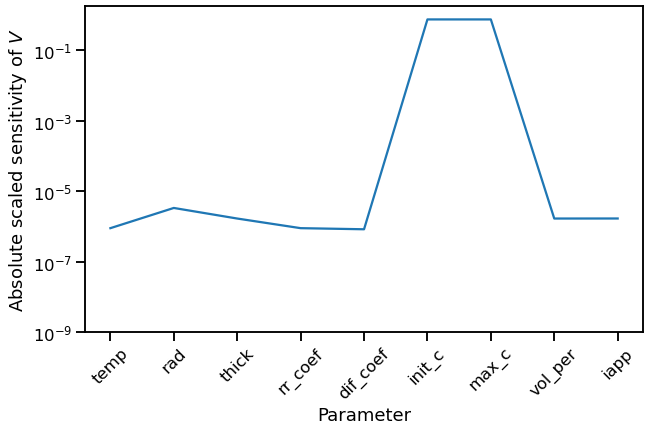

In [14]:
#plot as animation
fig, ax = plt.subplots(figsize=(10,6))

sim_steps = dat['sim_steps'][:][0]
x = np.arange(0, len(V_df.index), 1)
Y = []
for i in range (sim_steps):
    V_df = volts_df.copy()
    V_df['scaled_sensitivity'] = V_first_sensitivities[:, i]
    y = V_df['scaled_sensitivity'].abs().to_numpy()
    Y.append(y)

#time between frames
intervaltime = 0.5

#plot first frame
#V_df = volts_df.copy()
#V_df['scaled_sensitivity'] = V_first_sensitivities[:, 0]
#ax = V_df['scaled_sensitivity'].abs().plot(xticks=V_df.index, logy=True)
line, = plt.plot(x, Y[0])

#definition of animation
def animate(i):
    line.set_ydata(Y[i])
    return line,

#    V_df = volts_df.copy()
#    V_df['scaled_sensitivity'] = V_first_sensitivities[:, i]
#    ax = V_df['scaled_sensitivity'].abs().plot(xticks=V_df.index, logy=True)

ax.set_xticks(x)
ax.set_xticklabels(volts_df.parameter, rotation=45)
ax.set_ylabel('Absolute scaled sensitivity of $V$')
ax.set_xlabel('Parameter')
ax.set_ylim(np.min(Y)+10**(-9), np.max(Y)+1)
ax.set_yscale('log')

#plot animation
animate_sensitivities = FuncAnimation(fig, animate,interval=10, frames=range(1,sim_steps), blit=True)
animate_sensitivities.save('sensitivities.mp4')
plt.show()

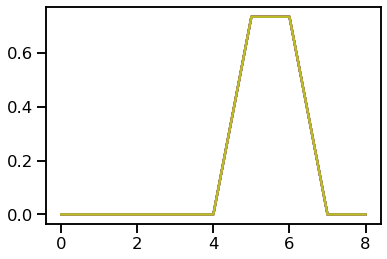

In [15]:
#temp
#rad
#thick
#rr_coef
#dif_coef
#init_c
#max_c
#vol_per
#iapp
for i in range(len(mu)):
    plt.plot(V_first_sensitivities[:, i])
#print(V_first_sensitivities[:, 0])
#print(V_first_sensitivities[:, 999])